In [1]:
import json
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import os
import random
import numpy as np

# 0. Leemos los datos

In [2]:
def read_json(path):
    with open(path) as f:
        data = json.load(f)
    return data

def leer_k_archivos_json(k):
    archivos_json = [archivo for archivo in os.listdir("data") if archivo.endswith('.json')]
    random.seed(42)
    paths = random.choices(archivos_json, k=k)

    all_playlists = []
    for p in paths:
        data = read_json(f"data\{p}")
        playlist = pd.DataFrame(data['playlists'])
        all_playlists.append(playlist)
    
    playlists = pd.concat(all_playlists, ignore_index=True)
    return playlists

In [3]:
# Leer 15 archivos json osea 15000 playlists
playlists = leer_k_archivos_json(15)
playlists.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,random,false,674000,1479168000,141,117,1,"[{'pos': 0, 'artist_name': 'R.E.M.', 'track_ur...",26,36307284,81,NaN
1,Summer 2015,false,674001,1471564800,191,155,1,"[{'pos': 0, 'artist_name': 'Kanye West', 'trac...",88,42162338,131,NaN
2,Dinner,false,674002,1501027200,26,24,1,"[{'pos': 0, 'artist_name': 'Dean Martin', 'tra...",2,6041217,21,NaN
3,Reggae,false,674003,1474156800,26,25,2,"[{'pos': 0, 'artist_name': 'Sizzla', 'track_ur...",4,5572231,16,NaN
4,angst,false,674004,1506902400,22,21,1,"[{'pos': 0, 'artist_name': 'Death Cab for Cuti...",5,5383303,19,NaN


In [69]:
playlists.isna().sum()

name                 0
collaborative        0
pid                  0
modified_at          0
num_tracks           0
num_albums           0
num_followers        0
num_edits            0
duration_ms          0
num_artists          0
description      14723
dtype: int64

In [67]:
playlists["description"][~playlists["description"].isna()]

105                             it was a long ass semester
123            intertwining your soul with somebody else ✨
161             for all of your &quot;non-Hype&quot; moods
208          free lil kodak they dont like to see u wining
233      theese are all the song i recomend wile workin...
                               ...                        
14667                                            lit music
14752    A playlist filled with all my current favorite...
14776                                      ALL SUMMER 2017
14827      The ultimate chill pill.  Kick back and unwind.
14895                              fun songs for any time!
Name: description, Length: 277, dtype: object

In [4]:
def expandir_tracks(playli):
    expanded_tracks_df = pd.DataFrame()

    # Iterar sobre cada fila y expandir los datos JSON en un dataframe
    for _, row in playli.iterrows():
        # Cargar el JSON desde la columna 'tracks'
        tracks = row['tracks']
        
        # Comprobar si 'tracks' es una cadena que necesita ser convertida de JSON
        if isinstance(tracks, str):
            try:
                tracks = json.loads(tracks)  # Cargar la cadena JSON
            except json.JSONDecodeError:
                tracks = []  # En caso de error, usar una lista vacía
        elif not isinstance(tracks, list):
            tracks = []  # Asegurar que tracks sea una lista si no es una cadena

        if tracks:
            track_data = json_normalize(tracks)
            track_data['pid'] = row['pid']  # añadimos el id de la playlist para mantener la referencia
            expanded_tracks_df = pd.concat([expanded_tracks_df, track_data], ignore_index=True)
    return expanded_tracks_df

In [5]:
expanded_tracks_df = expandir_tracks(playlists)

In [6]:
#verificamos que no existen valores nan
expanded_tracks_df.isna().sum()

pos            0
artist_name    0
track_uri      0
artist_uri     0
track_name     0
album_uri      0
duration_ms    0
album_name     0
pid            0
dtype: int64

In [7]:
# verificamos que no existen duplicados
expanded_tracks_df.duplicated().sum()

0

In [8]:
# verificamos que no existen duplicados de track_uri en una misma playlist
expanded_tracks_df.duplicated(subset=['track_uri', 'pid']).sum()

12907

In [9]:
playlists.drop("tracks", axis=1, inplace=True)
playlists.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description
0,random,false,674000,1479168000,141,117,1,26,36307284,81,NaN
1,Summer 2015,false,674001,1471564800,191,155,1,88,42162338,131,NaN
2,Dinner,false,674002,1501027200,26,24,1,2,6041217,21,NaN
3,Reggae,false,674003,1474156800,26,25,2,4,5572231,16,NaN
4,angst,false,674004,1506902400,22,21,1,5,5383303,19,NaN


In [10]:
playlists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           15000 non-null  object
 1   collaborative  15000 non-null  object
 2   pid            15000 non-null  int64 
 3   modified_at    15000 non-null  int64 
 4   num_tracks     15000 non-null  int64 
 5   num_albums     15000 non-null  int64 
 6   num_followers  15000 non-null  int64 
 7   num_edits      15000 non-null  int64 
 8   duration_ms    15000 non-null  int64 
 9   num_artists    15000 non-null  int64 
 10  description    277 non-null    object
dtypes: int64(8), object(3)
memory usage: 1.3+ MB


In [11]:
expanded_tracks_df.head()

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pid
0,0,R.E.M.,spotify:track:3ZSkJEf6bXoYzkJ4uXTL9s,spotify:artist:4KWTAlx2RvbpseOGMEmROg,Man On The Moon,spotify:album:3ImeTxETbPlg8S6cFNlova,314173,Automatic For The People,674000
1,1,R.E.M.,spotify:track:2oSpQ7QtIKTNFfA08Cy0ku,spotify:artist:4KWTAlx2RvbpseOGMEmROg,It's the End of the World As We Know It (And I...,spotify:album:6gMv3MgFlieOM6Uz5GZBzy,246933,Document (R.E.M. No. 5),674000
2,2,Billy Joel,spotify:track:78WVLOP9pN0G3gRLFy1rAa,spotify:artist:6zFYqv1mOsgBRQbae3JJ9e,Piano Man,spotify:album:77ErLrVvYETIlQJHAwhfIH,336200,Piano Man,674000
3,3,Christopher Cross,spotify:track:7gUMShP1l20tC0xf17Zplk,spotify:artist:695W5F2Ih8dYahLdjVOIoH,Ride Like The Wind,spotify:album:2m2nl8cBT7bEgIA6LLmgah,275506,Christopher Cross,674000
4,4,Chris Cross,spotify:track:3yPBHVaydiZWclK8hhdP5X,spotify:artist:6XyT3gg7czZif0WPIbhjFU,Arthur's Theme,spotify:album:5i2rQjhmJWEYNIGje1LU4R,231200,Gold - Burt Bacharach & Friends,674000


In [12]:
if (len(expanded_tracks_df["track_uri"].unique()) != len(expanded_tracks_df["track_name"].unique())):
    print("Existen canciones con el mismo nombre pero diferente URL")

Existen canciones con el mismo nombre pero diferente URL


Por lo anterior, usamos el URL para agrupar las canciones

In [13]:
expanded_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006380 entries, 0 to 1006379
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   pos          1006380 non-null  int64 
 1   artist_name  1006380 non-null  object
 2   track_uri    1006380 non-null  object
 3   artist_uri   1006380 non-null  object
 4   track_name   1006380 non-null  object
 5   album_uri    1006380 non-null  object
 6   duration_ms  1006380 non-null  int64 
 7   album_name   1006380 non-null  object
 8   pid          1006380 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 69.1+ MB


# 1. Analisis Exploratorio

In [14]:
playlists

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description
0,random,false,674000,1479168000,141,117,1,26,36307284,81,NaN
1,Summer 2015,false,674001,1471564800,191,155,1,88,42162338,131,NaN
2,Dinner,false,674002,1501027200,26,24,1,2,6041217,21,NaN
3,Reggae,false,674003,1474156800,26,25,2,4,5572231,16,NaN
4,angst,false,674004,1506902400,22,21,1,5,5383303,19,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14995,CHILL,false,683995,1436918400,5,5,1,2,1272182,5,NaN
14996,FEELS,false,683996,1504137600,12,10,1,9,2806829,8,NaN
14997,Awesome playlist,false,683997,1489968000,53,42,1,5,11921215,31,NaN
14998,Lizzie,false,683998,1500422400,69,62,1,21,15347835,48,NaN


In [15]:
expanded_tracks_df

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pid
0,0,R.E.M.,spotify:track:3ZSkJEf6bXoYzkJ4uXTL9s,spotify:artist:4KWTAlx2RvbpseOGMEmROg,Man On The Moon,spotify:album:3ImeTxETbPlg8S6cFNlova,314173,Automatic For The People,674000
1,1,R.E.M.,spotify:track:2oSpQ7QtIKTNFfA08Cy0ku,spotify:artist:4KWTAlx2RvbpseOGMEmROg,It's the End of the World As We Know It (And I...,spotify:album:6gMv3MgFlieOM6Uz5GZBzy,246933,Document (R.E.M. No. 5),674000
2,2,Billy Joel,spotify:track:78WVLOP9pN0G3gRLFy1rAa,spotify:artist:6zFYqv1mOsgBRQbae3JJ9e,Piano Man,spotify:album:77ErLrVvYETIlQJHAwhfIH,336200,Piano Man,674000
3,3,Christopher Cross,spotify:track:7gUMShP1l20tC0xf17Zplk,spotify:artist:695W5F2Ih8dYahLdjVOIoH,Ride Like The Wind,spotify:album:2m2nl8cBT7bEgIA6LLmgah,275506,Christopher Cross,674000
4,4,Chris Cross,spotify:track:3yPBHVaydiZWclK8hhdP5X,spotify:artist:6XyT3gg7czZif0WPIbhjFU,Arthur's Theme,spotify:album:5i2rQjhmJWEYNIGje1LU4R,231200,Gold - Burt Bacharach & Friends,674000
...,...,...,...,...,...,...,...,...,...
1006375,48,Drake,spotify:track:5InOp6q2vvx0fShv3bzFLZ,spotify:artist:3TVXtAsR1Inumwj472S9r4,Know Yourself,spotify:album:0ptlfJfwGTy0Yvrk14JK1I,275840,If You're Reading This It's Too Late,683999
1006376,49,Drake,spotify:track:5InOp6q2vvx0fShv3bzFLZ,spotify:artist:3TVXtAsR1Inumwj472S9r4,Know Yourself,spotify:album:0ptlfJfwGTy0Yvrk14JK1I,275840,If You're Reading This It's Too Late,683999
1006377,50,ABBA,spotify:track:1IxDBsZdVMhfkLqrZjARpk,spotify:artist:0LcJLqbBmaGUft1e9Mm8HV,Fernando,spotify:album:1M4anG49aEs4YimBdj96Oy,255533,Arrival,683999
1006378,51,DJ Esco,spotify:track:5oyUurs28XRagLa8lgm6V3,spotify:artist:2J0JN7EFN10G1Tty6hX0AN,Too Much Sauce,spotify:album:1pwl3JoaTkC10tQkodV4CN,223093,Too Much Sauce,683999


In [16]:
by_playlist = expanded_tracks_df.groupby('pid').agg(
    num_songs=('track_name', 'count'),  # Contamos el número de canciones por playlist
    avg_duration=('duration_ms', 'mean'),  # Calculamos la duración media de las canciones
    artists=('artist_name', lambda x: set(x)),  # Obtenemos un conjunto de artistas únicos
    songs =('track_uri', lambda x: set(x)),  # Obtenemos un conjunto de caciones únicas
    albums =('album_name', lambda x: set(x))  # Obtenemos un conjunto de albumes únicos
)

by_playlist['avg_duration'] = by_playlist['avg_duration'] / 60000 # Convertimos la duración de milisegundos a minutos
by_playlist.head()

,num_songs,avg_duration,artists,songs,albums
pid,,,,,
3000,16,3.630012,"{Lika Morgan, Joe Stone, Betty Who, Freischwim...","{spotify:track:20aGiCMoN89NFAEueKAi9d, spotify...","{The Party (This Is How We Do It), Should’ve B..."
3001,26,4.123429,"{Marsha Ambrosius, Lianne La Havas, Erykah Bad...","{spotify:track:74HYrIbnpc2xKCTenv5qKM, spotify...","{I Am, Who Is Jill Scott? - Words and Sounds, ..."
3002,12,3.570779,"{Fabri Fibra, Møme, AJR, Imagine Dragons, Zedd...","{spotify:track:6RUKPb4LETWmmr3iAEQktW, spotify...","{Shape of You, Taste The Weekend, Strip That D..."
3003,245,4.001794,"{Glass Animals, Chromatics, Rationale, Meadowl...","{spotify:track:1W7AVHQJRFjDMsEAVESWiT, spotify...","{Rationale, Hard Believer, Wet, Now Was Once t..."
3004,53,3.810601,"{Jace, IshDARR, My Chemical Romance, Flogging ...","{spotify:track:7BLBIXwIOXPSpTOh1YnKSA, spotify...","{Endgame, Greatest Hits, SIGNED and SEALED in ..."


In [17]:
by_playlist.describe()   

,num_songs,avg_duration
count,15000.000000,15000.000000
mean,67.092000,3.905535
std,54.135643,0.542220
min,5.000000,1.657109
25%,26.000000,3.647822
50%,50.000000,3.835903
75%,92.000000,4.076805
max,250.000000,20.185708


In [18]:
by_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 3000 to 901999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_songs     15000 non-null  int64  
 1   avg_duration  15000 non-null  float64
 2   artists       15000 non-null  object 
 3   songs         15000 non-null  object 
 4   albums        15000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 703.1+ KB


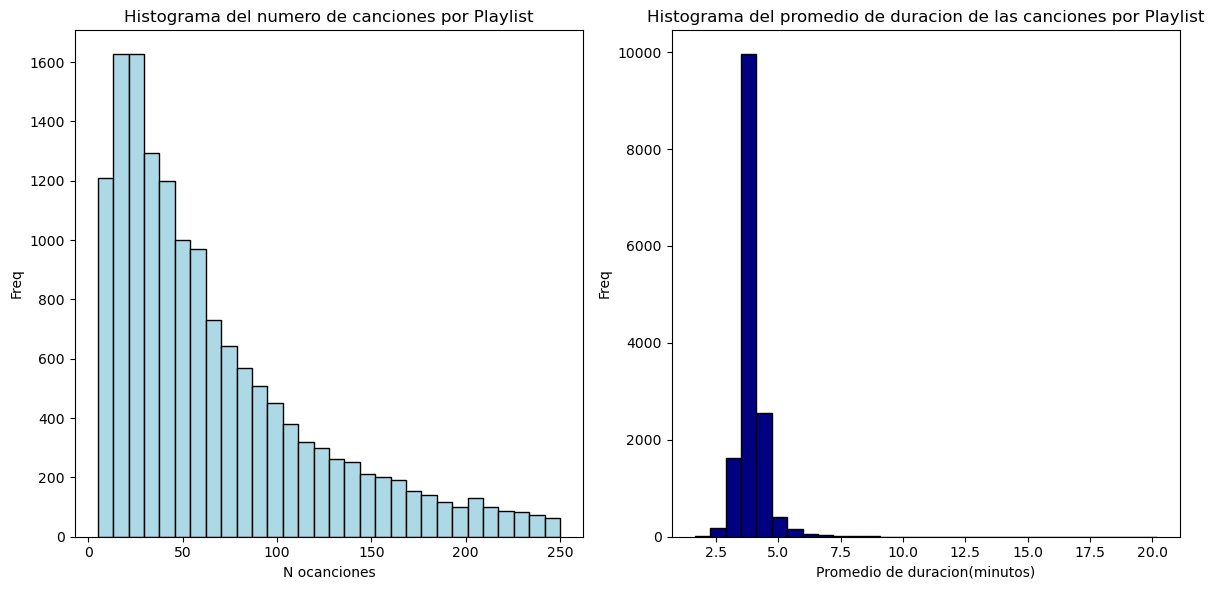

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Primer subplot para 'num_songs'
ax1.hist(by_playlist['num_songs'], bins=30, color='lightblue', edgecolor='black')
ax1.set_title('Histograma del numero de canciones por Playlist')
ax1.set_xlabel('N ocanciones')
ax1.set_ylabel('Freq')

# Segundo subplot para 'avg_duration'
ax2.hist(by_playlist['avg_duration'], bins=30, color='navy', edgecolor='black')
ax2.set_title('Histograma del promedio de duracion de las canciones por Playlist')
ax2.set_xlabel('Promedio de duracion(minutos)')
ax2.set_ylabel('Freq')

# Ajustar el layout para evitar la superposición de elementos
plt.tight_layout()

# Mostrar la figura con ambos subplots
plt.show()

In [20]:
n_artists = len(expanded_tracks_df["artist_name"].unique())
n_albums = len(expanded_tracks_df["album_name"].unique())
n_songs = len(expanded_tracks_df["track_uri"].unique())

print(f"Número de artistas únicos: {n_artists}, Número de canciones únicas: {n_songs}, Número de albumes únicos: {n_albums}")

Número de artistas únicos: 43552, Número de canciones únicas: 222222, Número de albumes únicos: 86556


In [21]:
playlist_per_song = expanded_tracks_df.groupby('track_uri')['pid'].agg(list).reset_index()
playlist_per_song.head()

,track_uri,pid
0,spotify:track:000pmJ2wC4EvNSbXa3aHwT,[176550]
1,spotify:track:000qnQ0A7HqxIm04z1R9T8,[553391]
2,spotify:track:000xQL6tZNLJzIrtIgxqSl,"[674120, 674982, 120045, 120092, 120110, 12019..."
3,spotify:track:000xYdQfIZ4pDmBGzQalKU,[674480]
4,spotify:track:0010mZpCCwlPwoBiBsjoac,"[120352, 761127, 124129]"


- Pasamos los URL a un id de cancion

In [22]:
url_id = {}
n = 1

def key_exists(key, dictionary):
    try:
        value = dictionary[key]
        return True
    except KeyError:
        return False

def get_id(x, n):
    if not key_exists(x, url_id):
        url_id[x] = n
        n += 1
    return url_id[x], n

values = []

for val in playlist_per_song["track_uri"]:
    valu, n = get_id(val, n)
    values.append(valu)

playlist_per_song["track_id"] = values
playlist_per_song.head()

,track_uri,pid,track_id
0,spotify:track:000pmJ2wC4EvNSbXa3aHwT,[176550],1
1,spotify:track:000qnQ0A7HqxIm04z1R9T8,[553391],2
2,spotify:track:000xQL6tZNLJzIrtIgxqSl,"[674120, 674982, 120045, 120092, 120110, 12019...",3
3,spotify:track:000xYdQfIZ4pDmBGzQalKU,[674480],4
4,spotify:track:0010mZpCCwlPwoBiBsjoac,"[120352, 761127, 124129]",5


In [23]:
expanded_tracks_df["track_id"] = expanded_tracks_df["track_uri"].apply(lambda x: url_id[x])

In [24]:
expanded_tracks_df

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pid,track_id
0,0,R.E.M.,spotify:track:3ZSkJEf6bXoYzkJ4uXTL9s,spotify:artist:4KWTAlx2RvbpseOGMEmROg,Man On The Moon,spotify:album:3ImeTxETbPlg8S6cFNlova,314173,Automatic For The People,674000,102011
1,1,R.E.M.,spotify:track:2oSpQ7QtIKTNFfA08Cy0ku,spotify:artist:4KWTAlx2RvbpseOGMEmROg,It's the End of the World As We Know It (And I...,spotify:album:6gMv3MgFlieOM6Uz5GZBzy,246933,Document (R.E.M. No. 5),674000,80541
2,2,Billy Joel,spotify:track:78WVLOP9pN0G3gRLFy1rAa,spotify:artist:6zFYqv1mOsgBRQbae3JJ9e,Piano Man,spotify:album:77ErLrVvYETIlQJHAwhfIH,336200,Piano Man,674000,203572
3,3,Christopher Cross,spotify:track:7gUMShP1l20tC0xf17Zplk,spotify:artist:695W5F2Ih8dYahLdjVOIoH,Ride Like The Wind,spotify:album:2m2nl8cBT7bEgIA6LLmgah,275506,Christopher Cross,674000,213171
4,4,Chris Cross,spotify:track:3yPBHVaydiZWclK8hhdP5X,spotify:artist:6XyT3gg7czZif0WPIbhjFU,Arthur's Theme,spotify:album:5i2rQjhmJWEYNIGje1LU4R,231200,Gold - Burt Bacharach & Friends,674000,113571
...,...,...,...,...,...,...,...,...,...,...
1006375,48,Drake,spotify:track:5InOp6q2vvx0fShv3bzFLZ,spotify:artist:3TVXtAsR1Inumwj472S9r4,Know Yourself,spotify:album:0ptlfJfwGTy0Yvrk14JK1I,275840,If You're Reading This It's Too Late,683999,151365
1006376,49,Drake,spotify:track:5InOp6q2vvx0fShv3bzFLZ,spotify:artist:3TVXtAsR1Inumwj472S9r4,Know Yourself,spotify:album:0ptlfJfwGTy0Yvrk14JK1I,275840,If You're Reading This It's Too Late,683999,151365
1006377,50,ABBA,spotify:track:1IxDBsZdVMhfkLqrZjARpk,spotify:artist:0LcJLqbBmaGUft1e9Mm8HV,Fernando,spotify:album:1M4anG49aEs4YimBdj96Oy,255533,Arrival,683999,37341
1006378,51,DJ Esco,spotify:track:5oyUurs28XRagLa8lgm6V3,spotify:artist:2J0JN7EFN10G1Tty6hX0AN,Too Much Sauce,spotify:album:1pwl3JoaTkC10tQkodV4CN,223093,Too Much Sauce,683999,166145


In [25]:
by_playlist["track_id"] = by_playlist["songs"].apply(lambda x: [url_id[val] for val in list(x)])
by_playlist.head()

,num_songs,avg_duration,artists,songs,albums,track_id
pid,,,,,,
3000,16,3.630012,"{Lika Morgan, Joe Stone, Betty Who, Freischwim...","{spotify:track:20aGiCMoN89NFAEueKAi9d, spotify...","{The Party (This Is How We Do It), Should’ve B...","[57401, 103488, 2230, 82090, 101056, 217176, 8..."
3001,26,4.123429,"{Marsha Ambrosius, Lianne La Havas, Erykah Bad...","{spotify:track:74HYrIbnpc2xKCTenv5qKM, spotify...","{I Am, Who Is Jill Scott? - Words and Sounds, ...","[201658, 89022, 187875, 9809, 178335, 208972, ..."
3002,12,3.570779,"{Fabri Fibra, Møme, AJR, Imagine Dragons, Zedd...","{spotify:track:6RUKPb4LETWmmr3iAEQktW, spotify...","{Shape of You, Taste The Weekend, Strip That D...","[183754, 150558, 148638, 47297, 199799, 159919..."
3003,245,4.001794,"{Glass Animals, Chromatics, Rationale, Meadowl...","{spotify:track:1W7AVHQJRFjDMsEAVESWiT, spotify...","{Rationale, Hard Believer, Wet, Now Was Once t...","[43308, 31944, 36035, 1857, 175000, 60611, 768..."
3004,53,3.810601,"{Jace, IshDARR, My Chemical Romance, Flogging ...","{spotify:track:7BLBIXwIOXPSpTOh1YnKSA, spotify...","{Endgame, Greatest Hits, SIGNED and SEALED in ...","[204892, 175369, 169627, 191340, 104008, 18037..."


In [26]:
playlist_per_song['n_playlists'] = playlist_per_song['pid'].apply(lambda x: len(set(x)))

In [27]:
playlist_per_song["n_playlists"].mean()

4.470632970632971

In [28]:
cancion_mas_reproducida = playlist_per_song["n_playlists"].idxmax()
playlist_per_song.iloc[cancion_mas_reproducida]

track_uri                   spotify:track:7KXjTSCq5nL1LoYtL7XAwS
pid            [674040, 674041, 674085, 674102, 674120, 67414...
track_id                                                  209065
n_playlists                                                  680
Name: 209064, dtype: object

In [29]:
playlist_per_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222222 entries, 0 to 222221
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   track_uri    222222 non-null  object
 1   pid          222222 non-null  object
 2   track_id     222222 non-null  int64 
 3   n_playlists  222222 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.8+ MB


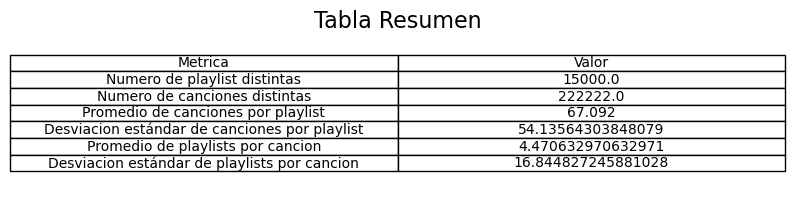

In [30]:
metricas = {
    'Metrica': ['Numero de playlist distintas', 'Numero de canciones distintas',
                'Promedio de canciones por playlist', 'Desviacion estándar de canciones por playlist',
                'Promedio de playlists por cancion', 'Desviacion estándar de playlists por cancion'],
    'Valor': [by_playlist.shape[0], n_songs, by_playlist["num_songs"].mean(), by_playlist["num_songs"].std(), 
              playlist_per_song["n_playlists"].mean(), playlist_per_song["n_playlists"].std()]
}

df = pd.DataFrame(metricas)

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tabla = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colWidths=[0.5, 0.5])
plt.title('Tabla Resumen', fontsize=16)
plt.show()

# 2. Baseline

In [31]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
#Hay playlist que tienen la misma cancion más de una vez, aca las tratamos solo una vez
playlist_track = expanded_tracks_df[["pid","track_id","track_name","duration_ms","artist_name"]].drop_duplicates()
playlist_track.head()

,pid,track_id,track_name,duration_ms,artist_name
0,674000,102011,Man On The Moon,314173,R.E.M.
1,674000,80541,It's the End of the World As We Know It (And I...,246933,R.E.M.
2,674000,203572,Piano Man,336200,Billy Joel
3,674000,213171,Ride Like The Wind,275506,Christopher Cross
4,674000,113571,Arthur's Theme,231200,Chris Cross


- Separamos en data de validación y data de entrenamiento

In [33]:
# elegimos el 60% de las playlist para entrenar el modelo
# Calcular el 60% del tamaño de la lista
num_elementos = int(0.6 * len(list(playlist_track["pid"].unique())))

pid_train = random.sample(list(playlist_track["pid"].unique()), num_elementos)

In [34]:
playlist_track_train = playlist_track[playlist_track['pid'].isin(pid_train)]
playlist_track_val = playlist_track[~playlist_track['pid'].isin(pid_train)]

In [35]:
playlist_track_train.shape[0] + playlist_track_val.shape[0] == playlist_track.shape[0]

True

In [36]:
from sklearn.preprocessing import LabelEncoder

label_encoder_customers = LabelEncoder()
playlist_id_encoded_train = label_encoder_customers.fit_transform(playlist_track_train['pid'])
playlist_id_encoded_val = label_encoder_customers.fit_transform(playlist_track_val['pid'])

label_encoder_articles = LabelEncoder()
song_id_encoded_train = label_encoder_articles.fit_transform(playlist_track_train['track_id'])
song_id_encoded_val = label_encoder_articles.fit_transform(playlist_track_val['track_id'])

interacciones_train = csr_matrix((np.ones(playlist_track_train.shape[0]), (playlist_id_encoded_train, song_id_encoded_train)))
interacciones_val = csr_matrix((np.ones(playlist_track_val.shape[0]), (playlist_id_encoded_val, song_id_encoded_val)))


def evaluar_als(dimension):
    modelo = AlternatingLeastSquares(factors=dimension)
    modelo.fit(interacciones_train)
    mapk = mean_average_precision_at_k(modelo, train_user_items=interacciones_train, test_user_items=interacciones_val, K=10)
    ndcgk = ndcg_at_k(modelo, train_user_items=interacciones_train, test_user_items=interacciones_val, K=10)
    return mapk, ndcgk

def evaluar_bpr(dimension):
    modelo = BayesianPersonalizedRanking(factors=dimension)
    modelo.fit(interacciones_train)
    mapk = mean_average_precision_at_k(modelo, train_user_items=interacciones_train, test_user_items=interacciones_val, K=10)
    ndcgk = ndcg_at_k(modelo, train_user_items=interacciones_train, test_user_items=interacciones_val, K=10)
    return mapk, ndcgk

In [37]:
dimensiones = [50, 100, 200, 500, 1000]

resultados_als = {}
resultados_bpr = {}

for dimension in dimensiones:
    mapk_als, ndcgk_als = evaluar_als(dimension)
    mapk_bpr, ndcgk_bpr = evaluar_bpr(dimension)

    resultados_als[dimension] = [mapk_als, ndcgk_als]
    resultados_bpr[dimension] = [mapk_bpr, ndcgk_bpr]

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
100%|██████████| 6000/6000 [00:16<00:00, 363.39it/s]


In [38]:
resultados_als

{50: [9.650793650793648e-05, 0.00038307060358246396],
 100: [0.00010894841269841272, 0.0004040581708969003],
 200: [0.00010517857142857144, 0.0003169654979492233],
 500: [0.00015221560846560847, 0.00048670240323394633],
 1000: [0.00012373015873015872, 0.00043646775088890857]}

In [39]:
resultados_bpr

{50: [0.00015161375661375663, 0.00045393909932633464],
 100: [0.00016038359788359788, 0.0005228624392704709],
 200: [0.00012244708994708995, 0.0004290319629241028],
 500: [8.400132275132278e-05, 0.000340841191483139],
 1000: [0.00013040343915343914, 0.0004617475549169731]}

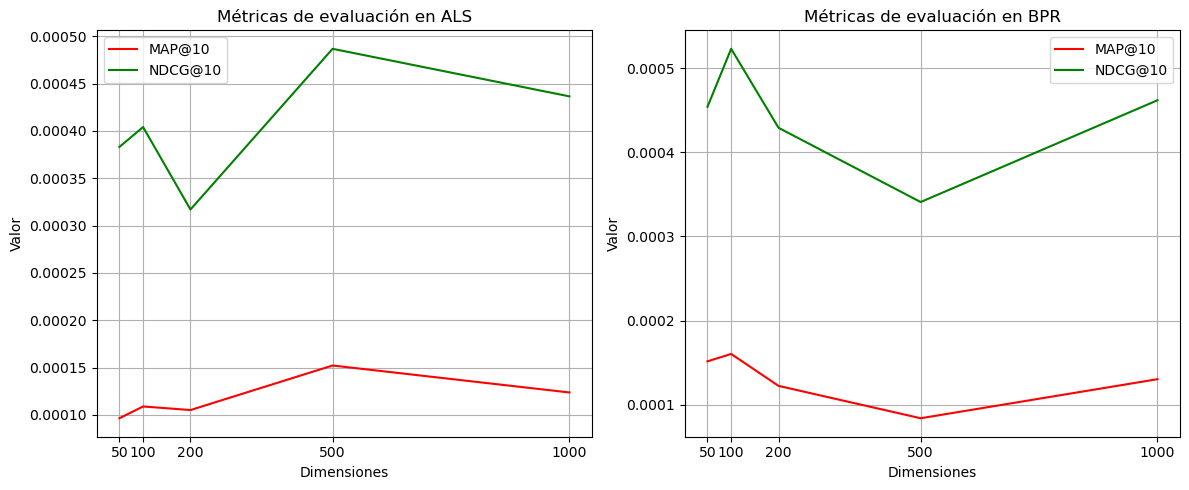

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico para ALS
axs[0].plot(dimensiones, [resultados_als[i][0] for i in dimensiones], label='MAP@10', color='red')
axs[0].plot(dimensiones, [resultados_als[i][1] for i in dimensiones], label='NDCG@10', color='green')
axs[0].set_title('Métricas de evaluación en ALS')
axs[0].set_xlabel('Dimensiones')
axs[0].set_ylabel('Valor')
axs[0].legend()
axs[0].set_xticks(dimensiones)
axs[0].grid(True)

# Gráfico para BPR
axs[1].plot(dimensiones, [resultados_bpr[i][0] for i in dimensiones], label='MAP@10', color='red')
axs[1].plot(dimensiones, [resultados_bpr[i][1] for i in dimensiones], label='NDCG@10', color='green')
axs[1].set_title('Métricas de evaluación en BPR')
axs[1].set_xlabel('Dimensiones')
axs[1].set_ylabel('Valor')
axs[1].legend()
axs[1].set_xticks(dimensiones)
axs[1].grid(True)

plt.tight_layout() 
plt.show()

# Item- Item

In [41]:
playlist_track_train

,pid,track_id,track_name,duration_ms,artist_name
141,674001,204205,All Day,310906,Kanye West
142,674001,120806,Blessings,252040,Big Sean
143,674001,93211,Classic Man,226000,Jidenna
144,674001,67885,Everyday,260986,A$AP Rocky
145,674001,160850,Ignition - Remix,186066,R. Kelly
...,...,...,...,...,...
1006253,683997,14308,Shooting Stars,235813,Bag Raiders
1006254,683997,166954,The Phantom Of The Opera,302800,Andrew Lloyd Webber
1006255,683997,74134,Love On The Brain,224000,Rihanna
1006256,683997,127830,Mercy,208733,Shawn Mendes


In [42]:
import tensorflow_hub as hub
import tensorflow as tf

In [43]:
modelo_use = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

Calculamos un embedding de texto para cada item (cancion) utilizando la info de su nombre (que info usaremos) mediante Universal Sentence Encoding

In [44]:
songs_embeddings = []

for i, row in playlist_track_train.iterrows():
    embedding = modelo_use([row['track_name']])
    songs_embeddings.append(embedding[0])

In [45]:
tensor = tf.convert_to_tensor(songs_embeddings)

In [46]:
from sklearn.decomposition import PCA

pca_10 = PCA(n_components=10, whiten=True)
X_pca_10 = pca_10.fit_transform(tensor.numpy())

In [47]:
def obtener_vec_item(X_n):
  items = []
  for i in range(X_n.shape[0]):
    vec_item = X_n[i]
    prod_norm = np.linalg.norm(vec_item)
    items.append((vec_item, prod_norm))
  return items

In [48]:
vectores_tracks_dim10 = obtener_vec_item(X_pca_10)

- Similaridad del Coseno

In [49]:
def simCos_per_item(v_item, prods_n):
  u_norm = np.linalg.norm(v_item)
  cosine_similarities = []
  for vec_item, item_norm in prods_n:
      cosine_similarity = np.dot(vec_item, v_item) / (item_norm * u_norm)
      cosine_similarities.append(cosine_similarity)
  return cosine_similarities

In [50]:
def batch_cosine_similarity(v_item, all_items, batch_size=1000):
    # Esta función calcula la similitud del coseno en lotes para evitar problemas de memoria
    start_idx = 0
    cosine_similarities = np.zeros(len(all_items))
    
    while start_idx < len(all_items):
        end_idx = min(start_idx + batch_size, len(all_items))
        batch = np.array([item[0] for item in all_items[start_idx:end_idx]])
        u_norm = np.linalg.norm(v_item)
        norms = np.linalg.norm(batch, axis=1)
        cosine_similarities[start_idx:end_idx] = np.dot(batch, v_item) / (norms * u_norm)
        start_idx = end_idx
    
    return cosine_similarities

# Ejemplo de uso:
# Similitud del primer item contra todos en lotes
similarities = batch_cosine_similarity(vectores_tracks_dim10[0][0], vectores_tracks_dim10)

In [51]:
len(similarities)

596282

In [52]:
def find_song_indices(track_name, artist_name, dataframe):
    """ Encuentra todos los índices de una canción específica basada en el nombre de la pista y el nombre del artista. """
    return dataframe[(dataframe['track_name'] == track_name) & (dataframe['artist_name'] == artist_name)].index.tolist()

def recommend_songs_batch(song_index, all_vectors, dataframe, top_n=5):
    track_name = dataframe.iloc[song_index]['track_name']
    artist_name = dataframe.iloc[song_index]['artist_name']

    song_vector = all_vectors[song_index][0]
    similarities = batch_cosine_similarity(song_vector, all_vectors)

    dataframe = dataframe.reset_index()
    
    # Obtener índices de todas las instancias de la canción actual
    song_indices = find_song_indices(track_name, artist_name, dataframe)
    for idx in song_indices:
        similarities[idx] = -np.inf  # Establece la similitud como infinito negativo

    similar_indices = np.argsort(-similarities)
    return similar_indices[:top_n]

# Hacer recomendaciones para la primera canción
recommended_indices = recommend_songs_batch(3,vectores_tracks_dim10, playlist_track_train)
print("Índices de canciones recomendadas:", recommended_indices)

Índices de canciones recomendadas: [ 31454  30137    906  33451 227929]


In [53]:
playlist_track_train

,pid,track_id,track_name,duration_ms,artist_name
141,674001,204205,All Day,310906,Kanye West
142,674001,120806,Blessings,252040,Big Sean
143,674001,93211,Classic Man,226000,Jidenna
144,674001,67885,Everyday,260986,A$AP Rocky
145,674001,160850,Ignition - Remix,186066,R. Kelly
...,...,...,...,...,...
1006253,683997,14308,Shooting Stars,235813,Bag Raiders
1006254,683997,166954,The Phantom Of The Opera,302800,Andrew Lloyd Webber
1006255,683997,74134,Love On The Brain,224000,Rihanna
1006256,683997,127830,Mercy,208733,Shawn Mendes


In [55]:
playlist_track_train.reset_index().iloc[31454]

index                  53647
pid                   674821
track_id               93021
track_name          Everyday
duration_ms           194840
artist_name    Ariana Grande
Name: 31454, dtype: object